In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [4]:
import sklearn
print(sklearn.__version__)

1.2.2


In [58]:
from sklearn.preprocessing import MinMaxScaler
from scipy.special import boxcox1p
from scipy.stats import boxcox

In [6]:
import pickle
from scipy import stats


In [7]:
model_path = '/content/drive/MyDrive/Colab Notebooks/Wine Quality Classification/model/'

In [8]:
RANDOM_STATE = 39

In [9]:
data_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Wine Quality Classification/WineQT.csv")

In [10]:
data_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [11]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [12]:
data_df.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'Id'],
      dtype='object')

In [13]:
data_df.quality.value_counts()

5    483
6    462
7    143
4     33
8     16
3      6
Name: quality, dtype: int64

In [14]:
data_df.drop(["Id"], axis = 1, inplace = True)

In [15]:
data_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [16]:
def wineQualityTransform(quality):
    wine_quality_transformation = {3: 0, 4: 0, 5:1, 6:2, 7: 3, 8: 3}
    return wine_quality_transformation[quality]

data_df["quality"] = data_df["quality"].apply(wineQualityTransform)
print(data_df.quality.value_counts())


1    483
2    462
3    159
0     39
Name: quality, dtype: int64


[Text(0, 0, '39'), Text(0, 0, '483'), Text(0, 0, '462'), Text(0, 0, '159')]

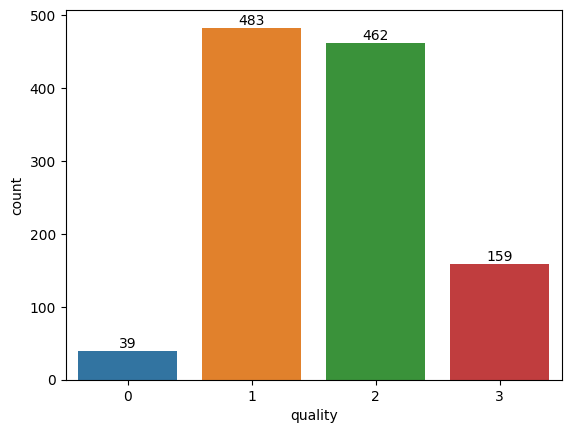

In [17]:
ax = sns.countplot(x = "quality", data = data_df)
ax.bar_label(ax.containers[0])

So, we still have highly imbalanced data. For the handling of imbalanced data, we are going to use various methods like oversampling, undersampling, smote and class weights.

In [18]:
from sklearn.model_selection import train_test_split

X = data_df.drop("quality", axis = 1)
y = data_df.quality

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE, stratify = y)

In [19]:
def qualityBarplot(qualitySeries):
    count_calc = qualitySeries.value_counts()
    print(count_calc)
    f, ax = plt.subplots(1, 1, figsize = (10, 5))
    g = sns.barplot(x = count_calc.index, y = count_calc, ax = ax)
    g.set(xlabel = "quality", ylabel = "count")
    g.bar_label(g.containers[0])

1    386
2    370
3    127
0     31
Name: quality, dtype: int64
1    97
2    92
3    32
0     8
Name: quality, dtype: int64


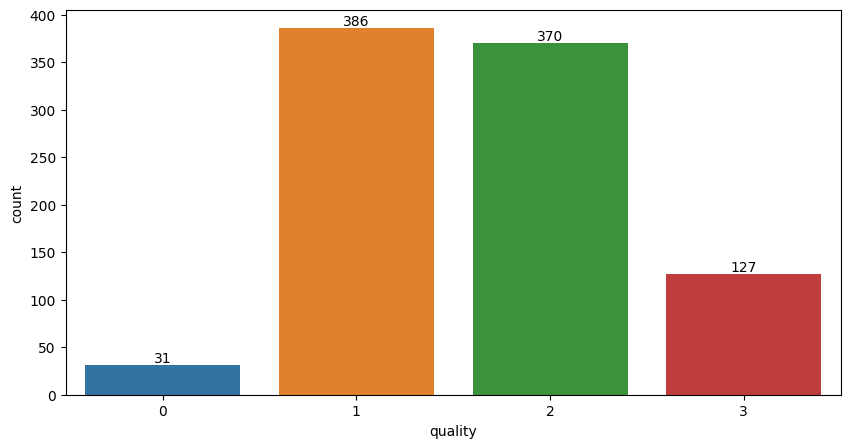

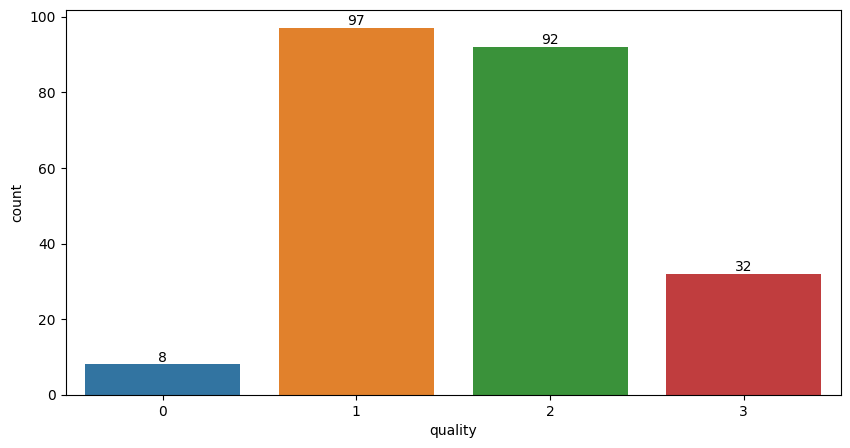

In [20]:
qualityBarplot(y_train)
qualityBarplot(y_test)

In [21]:
y_train

896     2
651     1
813     3
94      1
1065    1
       ..
885     1
666     3
144     2
592     3
257     1
Name: quality, Length: 914, dtype: int64

## XBGClassifier




In [56]:
X_train["fixed acidity"]

896     10.4
651      9.6
813     10.0
94       7.2
1065     6.2
        ... 
885      7.9
666      8.3
144      7.0
592      7.5
257     11.9
Name: fixed acidity, Length: 914, dtype: float64

In [23]:
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [24]:
fileName = "min_max_scaler_2.pkl"
with open(model_path + fileName, 'wb') as f:
  pickle.dump(scaler, f)

In [27]:
data = scaler.transform(X_train)
data

array([[0.51327434, 0.25619835, 0.5       , ..., 0.28346457, 0.32335329,
        0.46153846],
       [0.44247788, 0.23966942, 0.37      , ..., 0.39370079, 0.13772455,
        0.32307692],
       [0.47787611, 0.23966942, 0.45      , ..., 0.37007874, 0.09580838,
        0.52307692],
       ...,
       [0.21238938, 0.25619835, 0.36      , ..., 0.47244094, 0.13772455,
        0.12307692],
       [0.25663717, 0.12396694, 0.34      , ..., 0.51968504, 0.18562874,
        0.4       ],
       [0.6460177 , 0.38016529, 0.66      , ..., 0.24409449, 0.13772455,
        0.24615385]])

In [35]:
data_dataframe = pd.DataFrame(data)
data_dataframe

,0,1,2,3,4,5,6,7,8,9,10
0,0.513274,0.256198,0.50,0.095890,0.093645,0.179104,0.045936,0.435389,0.283465,0.323353,0.461538
1,0.442478,0.239669,0.37,0.095890,0.132107,0.134328,0.060071,0.571953,0.393701,0.137725,0.323077
2,0.477876,0.239669,0.45,0.363014,0.098662,0.074627,0.028269,0.510279,0.370079,0.095808,0.523077
3,0.230088,0.243802,0.36,0.075342,0.115385,0.179104,0.137809,0.523495,0.582677,0.185629,0.123077
4,0.141593,0.438017,0.06,0.047945,0.063545,0.074627,0.042403,0.250367,0.653543,0.125749,0.546154
...,...,...,...,...,...,...,...,...,...,...,...
909,0.292035,0.446281,0.00,0.034247,0.140468,0.074627,0.024735,0.412628,0.543307,0.149701,0.169231
910,0.327434,0.148760,0.49,0.198630,0.130435,0.149254,0.063604,0.360499,0.417323,0.185629,0.569231
911,0.212389,0.256198,0.36,0.047945,0.128763,0.194030,0.109541,0.446402,0.472441,0.137725,0.123077
912,0.256637,0.123967,0.34,0.095890,0.063545,0.044776,0.007067,0.369310,0.519685,0.185629,0.400000


In [70]:
def scaleAndTransform(data, scaler):
  data = scaler.transform(data)
  data = data + 0.0001
  for i in range(data.shape[1]):
    data[:, i], _ = boxcox(data[:, i])
  
  return data

In [71]:
X_train_transformed = scaleAndTransform(X_train, scaler)
X_test_transformed = scaleAndTransform(X_test, scaler)

In [72]:
X_train_transformed

array([[-0.57633102, -0.90427452, -0.59018061, ..., -0.77451127,
        -0.97539691, -0.68840987],
       [-0.68279995, -0.93126038, -0.79177374, ..., -0.64436119,
        -1.54129032, -0.95512064],
       [-0.62847684, -0.93126038, -0.66403283, ..., -0.67172219,
        -1.74564055, -0.58770089],
       ...,
       [-1.11666927, -0.90427452, -0.80872218, ..., -0.55487256,
        -1.54129032, -1.5464742 ],
       [-1.01808236, -1.14365101, -0.84337475, ..., -0.50229007,
        -1.35778879, -0.79892446],
       [-0.39667154, -0.71831883, -0.37684925, ..., -0.82276858,
        -1.54129032, -1.13977962]])

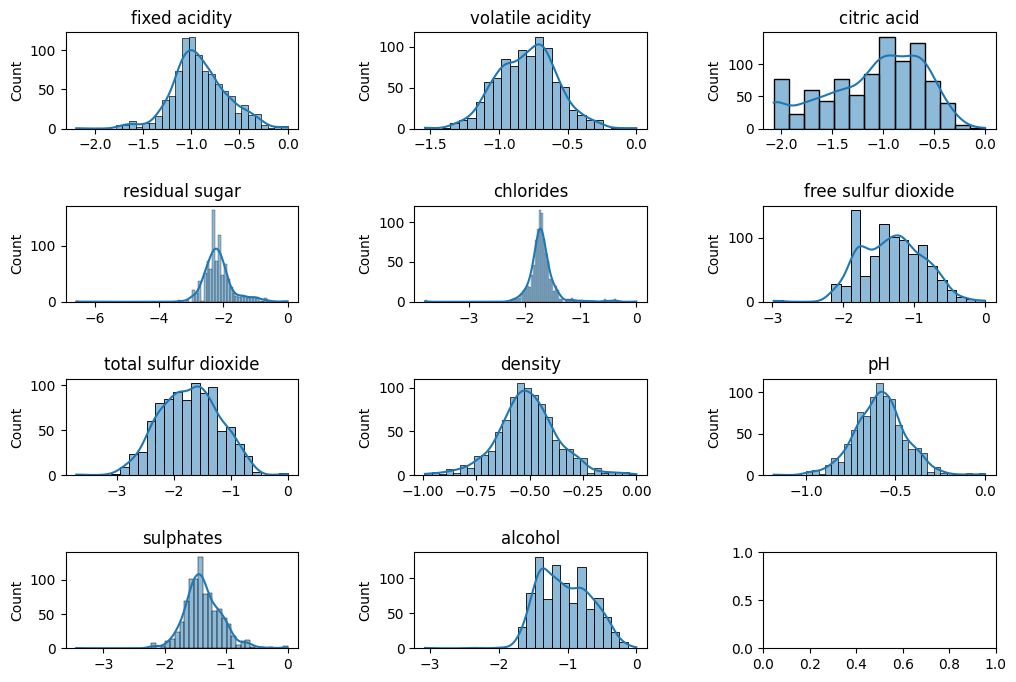

In [73]:
## distribution plot of the boxcox transformed data
column_names = data_df.columns
NUM_ROWS = 4
NUM_COLS = 3
fig, axs = plt.subplots(NUM_ROWS, NUM_COLS)
fig.set_size_inches(12, 8)
fig.subplots_adjust(wspace = 0.5, hspace = 0.8)

for row in range(NUM_ROWS):
  for col in range(NUM_COLS): 
    if row == 3 and col == 2:
      continue  
    ax = axs[row][col]
    sns.histplot(X_train_transformed[:, NUM_COLS * row + col], ax = ax, kde = True)
    ax.set_title(column_names[NUM_COLS * row + col])

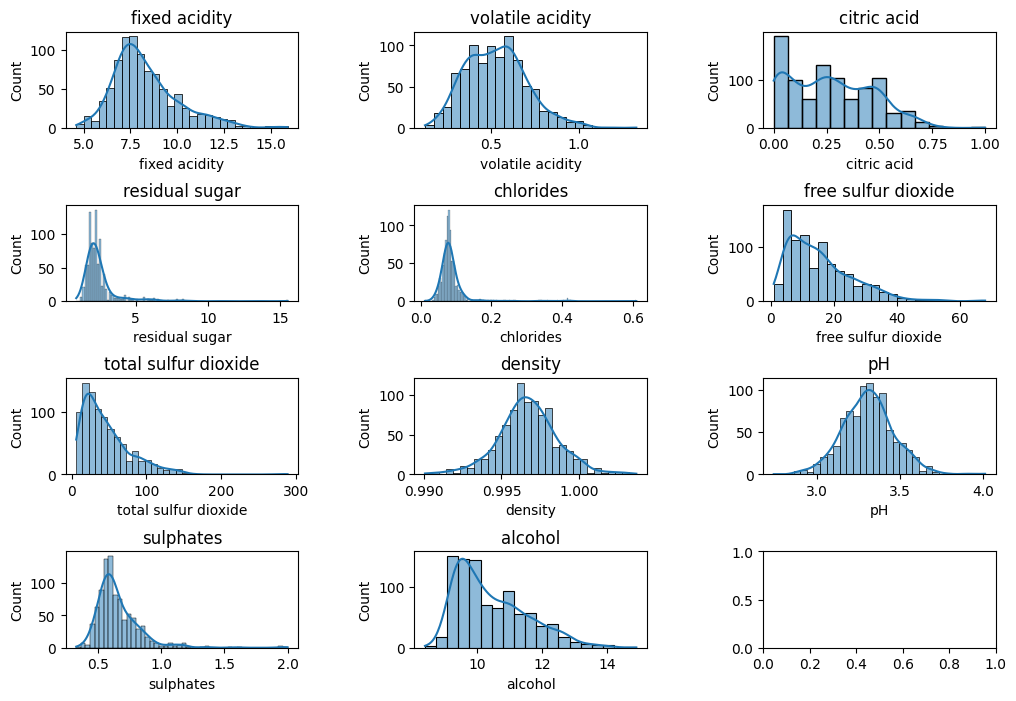

In [74]:
## distribution plot of the boxcox transformed data
column_names = data_df.columns
NUM_ROWS = 4
NUM_COLS = 3
fig, axs = plt.subplots(NUM_ROWS, NUM_COLS)
fig.set_size_inches(12, 8)
fig.subplots_adjust(wspace = 0.5, hspace = 0.8)

for row in range(NUM_ROWS):
  for col in range(NUM_COLS): 
    if row == 3 and col == 2:
      continue  
    ax = axs[row][col]
    sns.histplot(X_train[column_names[NUM_COLS * row + col]], ax = ax, kde = True)
    ax.set_title(column_names[NUM_COLS * row + col])

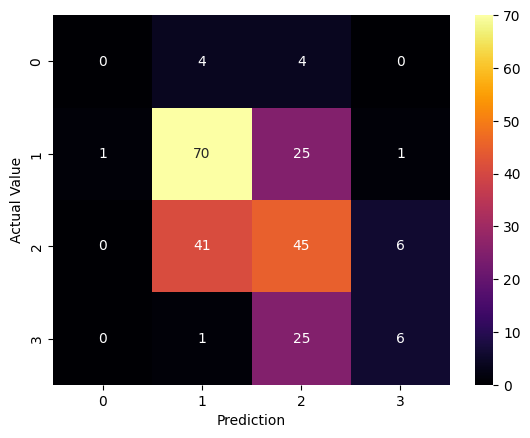


              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.60      0.72      0.66        97
           2       0.45      0.49      0.47        92
           3       0.46      0.19      0.27        32

    accuracy                           0.53       229
   macro avg       0.38      0.35      0.35       229
weighted avg       0.50      0.53      0.50       229



In [75]:
xgbv1 = XGBClassifier()
xgbv1.fit(X_train_transformed, y_train)

y_pred = xgbv1.predict(X_test_transformed)

cm = confusion_matrix(y_true = y_test, y_pred = y_pred)
sns.heatmap(cm, annot = True, cmap = 'inferno')
plt.xlabel("Prediction")
plt.ylabel("Actual Value")
plt.show()

print()
print(classification_report(y_true = y_test, y_pred = y_pred))